In [62]:
#DO ALL PROCESS AT ONE TIME
from imp import reload 
import sys
from allProcess import *
reload(sys.modules['allProcess'])
from allProcess import *

IMG_LIST = ['facebook1']
IMG_LIST = list(range(6307,6316))
#((w1+h1>f*7) and (w2+h2>f*7))
for i in IMG_LIST:
    print('===========PROCESSING IMAGE NUMBER '+str(i)+'=============')
    allProcess(str(i), False)
    ##一般測試experiment設為false

===========PROCESSING IMAGE NUMBER 6307=============
image size:  2436 * 1125
lowThreshold, highThreshold, mean: 14 29 148.422617040686
canny mean: 6.264969896004379
canny mean after dilate by 7 : 60.42313628899836
number of contour result: 177
number of contours after filted by hierarchy: 61
number of contours after filted by size: 59
number of contours after filted out img noises: 48
Logical Processors:  8
round[0]Box[0]thread[1]: x=974, y=2290, w=73, h=43, confidence: 96, text: 我的round[0]Box[0]thread[3]: x=300, y=2290, w=72, h=43, confidence: 95, text: 熱門round[0]Box[0]thread[6]: x=525, y=2289, w=72, h=44, confidence: 95, text: 搜尋 [5, [6, 4, -1, -1]]
 round[0]Box[0]thread[2]: x=750, y=2290, w=72, h=43, confidence: 96, text: 通知 round[0]Box[0]thread[7]: x=527, y=2209, w=70, h=70, confidence: 92, text: Qround[0]Box[0]thread[5]: x=75, y=2290, w=73, h=43, confidence: 93, text: 發現[3, [4, 2, -1, -1]] [1, [2, 0, -1, -1]]
 [2, [3, 1, -1, -1]]
[6, [8, 5, 7, -1]]

 [4, [5, 3, -1, -1]]
get text 

round[0]Box[0]thread[2]: x=752, y=2292, w=68, h=39, confidence: 94, text: 通知round[0]Box[0]thread[5]: x=527, y=2291, w=68, h=40, confidence: 93, text: 搜尋 [3, [4, 2, -1, -1]]
 [6, [7, 5, -1, -1]]
round[0]Box[0]thread[3]: x=466, y=1935, w=125, h=43, confidence: 96, text: Collage [69, [70, 30, -1, -1]]
get text thinner
round[0]Box[0]thread[2]: x=307, y=2209, w=59, h=70, confidence: 78, text: @ [14, [17, 11, 15, -1]]
round[0]Box[0]thread[2]: x=81, y=1919, w=31, h=42, confidence: 96, text: 5 [71, [72, 70, -1, -1]]
get text thinner
round[0]Box[0]thread[5]: x=976, y=2209, w=72, h=68, confidence: 50, text: >) [11, [14, 9, 12, -1]]
get text thicker
round[0]Box[0]thread[1]: x=77, y=2209, w=70, h=70, confidence: 42, text: 8 [17, [20, 14, 18, -1]]
get text thicker
round[0]Box[0]thread[4]: x=1008, y=2127, w=42, h=17, confidence: 0, text:  [21, [22, 20, -1, -1]]
get text thicker
round[0]Box[0]thread[3]: x=1008, y=1932, w=42, h=17, confidence: 0, text:  [70, [71, 69, -1, -1]]
round[0]Box[0]thread[3]: 

Logical Processors:  8
round[0]Box[0]thread[7]: x=527, y=2209, w=70, h=70, confidence: 92, text: Qget text thicker
round[0]Box[0]thread[1]: x=750, y=2290, w=72, h=43, confidence: 96, text: 通知  [6, [8, 5, 7, -1]]
round[0]Box[0]thread[2]: x=974, y=2290, w=73, h=43, confidence: 96, text: 我的round[0]Box[0]thread[0]: x=754, y=2208, w=65, h=71, confidence: 0, text: [2, [3, 1, -1, -1]] round[0]Box[0]thread[4]: x=300, y=2290, w=72, h=43, confidence: 95, text: 熱門
[8, [10, 6, 9, -1]]  
[1, [2, 0, -1, -1]][4, [5, 3, -1, -1]]round[0]Box[0]thread[6]: x=75, y=2290, w=73, h=43, confidence: 93, text: 發現

 [5, [6, 4, -1, -1]]
round[0]Box[0]thread[3]: x=525, y=2290, w=72, h=43, confidence: 95, text: 搜尋 [3, [4, 2, -1, -1]]
round[0]Box[0]thread[1]: x=81, y=843, w=121, h=48, confidence: 92, text: 金曲獎 [24, [25, 23, -1, -1]]
round[0]Box[0]thread[3]: x=519, y=735, w=121, h=48, confidence: 92, text: 老破麻 [27, [28, 26, -1, -1]]
get text thinner
round[0]Box[0]thread[2]: x=75, y=2207, w=74, h=74, confidence: 78, te

round[0]Box[0]thread[7]: x=45, y=195, w=219, h=113, confidence: 96, text: 我的 [89, [96, 86, 90, -1]]
get text thickerget text thicker
round[0]Box[0]thread[0]: x=362, y=459, w=119, h=120, confidence: 50, text: @ [82, [86, 79, 83, -1]]

round[0]Box[0]thread[7]: x=875, y=46, w=65, h=46, confidence: 0, text:  [99, [100, 96, -1, -1]]
get text thinner
round[0]Box[0]thread[3]: x=377, y=474, w=90, h=90, confidence: 47, text: ® [83, [-1, -1, 84, 82]]
round[0]Box[0]thread[6]: x=70, y=45, w=139, h=48, confidence: 93, text: 03:55 [100, [101, 99, -1, -1]]
get text thinner
round[0]Box[0]thread[1]: x=391, y=488, w=61, h=61, confidence: 67, text: ® [84, [-1, -1, 85, 83]]
get text thicker
round[0]Box[0]thread[4]: x=81, y=459, w=119, h=120, confidence: 41, text: @ [86, [89, 82, 87, -1]]
get text thicker
round[0]Box[0]thread[6]: x=950, y=185, w=134, h=134, confidence: 54, text: @ [96, [99, 89, 97, -1]]
get text thicker
round[0]Box[0]thread[3]: x=939, y=474, w=90, h=90, confidence: 61, text: 4> ” [77, [-1,

round[0]Box[0]thread[6]: x=207, y=1874, w=45, h=48, confidence: 95, text: in [43, [44, 42, -1, -1]]
get text thinner
round[0]Box[0]thread[5]: x=75, y=2207, w=74, h=74, confidence: 78, text: 0 [14, [23, 11, 15, -1]]
get text thinner
round[0]Box[0]thread[0]: x=974, y=2207, w=76, h=72, confidence: 21, text: 6) [10, [11, 8, -1, -1]]
get text thicker
round[0]Box[0]thread[4]: x=305, y=2207, w=63, h=74, confidence: 35, text: ® [11, [14, 10, 12, -1]]
round[0]Box[0]thread[3]: x=71, y=1532, w=549, h=57, confidence: 90, text: http://offscoreproject.com [45, [46, 44, -1, -1]]
round[0]Box[0]thread[3]: x=656, y=878, w=122, h=121, confidence: 96, text: + [62, [65, 58, 63, -1]]
get text thicker
round[0]Box[0]thread[4]: x=785, y=879, w=122, h=120, confidence: 0, text:  [58, [62, 57, 59, -1]]
round[0]Box[0]thread[1]: x=56, y=1723, w=128, h=70, confidence: 96, text: 歌詞 [44, [45, 43, -1, -1]]
round[0]Box[0]thread[2]: x=56, y=1381, w=128, h=70, confidence: 94, text: 介紹 [46, [47, 45, -1, -1]]
round[0]Box[0]

get text thicker
round[0]Box[0]thread[5]: x=1101, y=997, w=24, h=43, confidence: 0, text:  [109, [110, 108, -1, -1]]
round[0]Box[0]thread[5]: x=304, y=947, w=128, h=45, confidence: 96, text: demo [110, [111, 109, -1, -1]]
get text thinner
round[0]Box[0]thread[7]: x=150, y=1949, w=282, h=96, confidence: 59, text: 「 [25, [29, 21, 26, -1]]
get text thinner
round[0]Box[0]thread[3]: x=666, y=1949, w=282, h=96, confidence: 59, text: 「 [21, [25, 20, 22, -1]]
round[0]Box[0]thread[4]: x=57, y=1270, w=248, h=67, confidence: 92, text: 精選藝人 [105, [107, 103, 106, -1]]
round[0]Box[0]thread[3]: x=796, y=943, w=166, h=54, confidence: 96, text: (Demo) [117, [121, 112, 118, -1]]
get text thinner
round[0]Box[0]thread[5]: x=1100, y=944, w=25, h=52, confidence: 64, text: 和 [111, [112, 110, -1, -1]]
round[0]Box[0]thread[3]: x=69, y=943, w=296, h=98, confidence: 90, text: 牢馭金牛座de 海雅谷慕地下頭目 [121, [125, 117, 122, -1]]
round[0]Box[0]thread[3]: x=913, y=822, w=94, h=91, confidence: 89, text: > [140, [143, 139, 14

round[0]Box[0]thread[6]: x=964, y=945, w=94, h=94, confidence: 73, text: x [138, [140, 137, 139, 132]]
get text thinner
round[0]Box[0]thread[6]: x=436, y=948, w=94, h=91, confidence: 59, text: 2G [201, [203, 200, 202, 195]]
get text thicker
round[0]Box[0]thread[6]: x=536, y=388, w=18, h=22, confidence: 0, text:  [308, [309, 195, -1, -1]]
round[0]Box[0]thread[6]: x=445, y=325, w=29, h=41, confidence: 80, text: ? [310, [311, 309, -1, -1]]
round[0]Box[0]thread[1]: x=42, y=1016, w=1041, h=251, confidence: 86, text: __ SoundOf2020(P...SoundOf2020(P... 小樹小樹 [129, [130, 128, -1, -1]]
round[0]Box[0]thread[1]: x=943, y=51, w=56, h=38, confidence: 95, text: 4G [330, [331, 329, -1, -1]]
get text thicker
round[0]Box[0]thread[1]: x=877, y=48, w=61, h=42, confidence: 0, text:  [331, [332, 330, -1, -1]]
round[0]Box[0]thread[1]: x=72, y=47, w=136, h=44, confidence: 94, text: 03:56 [332, [334, 331, 333, -1]]
get text thicker
round[0]Box[0]thread[1]: x=1003, y=46, w=85, h=46, confidence: 0, text:  [334,

round[0]Box[0]thread[4]: x=547, y=817, w=58, h=49, confidence: 96, text: ft. [93, [94, 92, -1, -1]]
round[0]Box[0]thread[7]: x=147, y=978, w=184, h=184, confidence: 73, text: 圖 [83, [91, 82, 84, -1]]
get text thicker
round[0]Box[0]thread[0]: x=147, y=1173, w=184, h=183, confidence: 47, text: i [77, [80, 75, 78, -1]]
get text thicker
round[0]Box[0]thread[0]: x=355, y=2389, w=416, h=30, confidence: 14, text: De [0, [1, -1, -1, -1]]
get text thicker
round[0]Box[0]thread[0]: x=153, y=783, w=174, h=34, confidence: 0, text:  [101, [102, 100, -1, -1]]
get text thicker
round[0]Box[0]thread[2]: x=162, y=993, w=154, h=154, confidence: 52, text: ˋ7 [89, [-1, 88, 90, 83]]
get text thicker
round[0]Box[0]thread[3]: x=1006, y=865, w=46, h=21, confidence: 0, text:  [91, [92, 83, -1, -1]]
round[0]Box[0]thread[2]: x=64, y=657, w=63, h=47, confidence: 96, text: 43 [103, [104, 102, -1, -1]]
round[0]Box[0]thread[7]: x=353, y=814, w=193, h=95, confidence: 91, text: 舉刀自盡 [95, [100, 94, 96, -1]]
round[0]Box[0

In [4]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt


IMAGE_NUMBER = str('6310')
#IMAGE_NUMBER = 'facebook'
# img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)
# h,w,_ = img.shape
# img = cv2.resize(img, (int(w*0.5),int(h*0.5)))
# cv2.imwrite('iosScreenshot/IMG_'+IMAGE_NUMBER+'1.png', img)
# plt.figure(figsize=(50,25))
# plt.imshow(img)

image size:  2436 * 1125
lowThreshold, highThreshold, mean: 7 14 70.38493559569422
canny mean: 8.583371647509578
canny mean after dilate by 5 : 68.56406130268199
number of contour result: 374
number of contours after filted by hierarchy: 60
number of contours after filted by size: 58
number of contours after filted out img noises: 38


<Figure size 3600x1800 with 0 Axes>

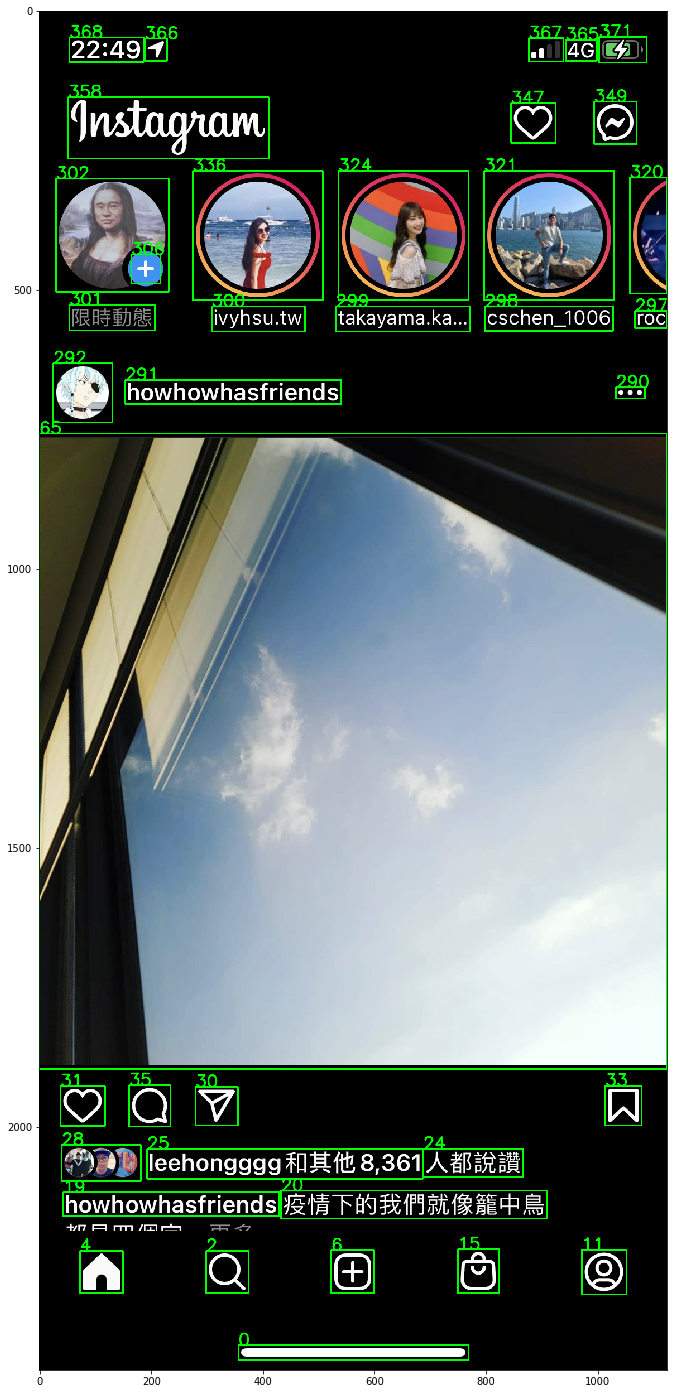

In [5]:
from getContourInfo import *
reload(sys.modules['getContourInfo'])
from getContourInfo import *

img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)
img = cv2.imread('experiment/2.png', 1)
height,width,_ = img.shape

print('image size: ', height, '*', width)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lowThreshold, highThreshold, mean = updateLowHighThreshold(gray)
print("lowThreshold, highThreshold, mean:",lowThreshold, highThreshold, mean)

blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
gray_edges = cv2.Canny(blur_gray, lowThreshold, highThreshold)

mean_canny = np.average(gray_edges)
print('canny mean:',mean_canny)

if mean_canny<=7:
    i=7
elif 7<mean_canny<17:
    i=5
else:
    i=3

gray_edges = addDilate(gray_edges, i)
#加深edge
mean_canny = np.average(gray_edges)

print('canny mean after dilate by '+str(i)+' :',mean_canny)

cv2.imwrite('result/canny.jpg', gray_edges)

result, hierarchy, contourInfo = getContourInfo(gray_edges)

contourInfo = removeImgNoise(contourInfo, gray)
print('number of contours after filted out img noises:', len(contourInfo))

clone = img.copy()
for c in result:
    (x, y, w, h) = cv2.boundingRect(c)
    #if w>=30 and h>=30: 
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #長方形框出contour

cv2.imwrite('result/'+IMAGE_NUMBER+'.png', clone)
plt.figure(figsize=(50,25))
clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
#matplotlib needs to change to rgb
#plt.imshow(clone)

#利用hierarchy 資訊篩選重要的contours
#print(result)
#print(len(hierarchy[0]))
#print(hierarchy[0])
#同層下一個輪廓的序號、同層上一個輪廓的序號、子輪廓的序號、父輪廓的序號。
#contourInfo: [[輪廓編號, 輪廓hier資訊],[輪廓座標]]
clone2 = img.copy()
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(clone2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone2, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

cv2.imwrite('result/better_'+IMAGE_NUMBER+'.png', clone2)
plt.figure(figsize=(50,25))
clone2 = cv2.cvtColor(clone2, cv2.COLOR_BGR2RGB)
plt.imshow(clone2)

filt = [n for n in contourInfo if n[0][1][3]!=-1]
#篩選條件用
#print(filt)


Logical Processors:  8
round[0]Box[0]thread[1]: x=523, y=2221, w=77, h=77, confidence: 89, text: (+)round[0]Box[0]thread[4]: x=299, y=2222, w=76, h=76, confidence: 92, text: Qround[0]Box[0]thread[2]: x=73, y=2222, w=77, h=76, confidence: 94, text: A   [6, [11, 4, 7, -1]][4, [6, 2, 5, -1]][2, [4, 0, 3, -1]]


get text thinner
round[0]Box[0]thread[1]: x=750, y=2219, w=74, h=79, confidence: 64, text: 台 [15, [18, 11, 16, -1]]
round[0]Box[0]thread[4]: x=688, y=2039, w=179, h=50, confidence: 90, text: 人都說讚 [24, [25, 20, -1, -1]]
get text thicker
round[0]Box[0]thread[3]: x=972, y=2220, w=80, h=80, confidence: 48, text: © [11, [15, 6, 12, -1]]
round[0]Box[0]thread[1]: x=280, y=1928, w=76, h=69, confidence: 79, text: V [30, [31, 28, -1, -1]]
round[0]Box[0]thread[1]: x=161, y=1925, w=74, h=74, confidence: 92, text: Q [35, [37, 33, 36, -1]]
round[0]Box[0]thread[6]: x=43, y=2117, w=387, h=43, confidence: 87, text: howhowhasfriendsget text thinner
round[0]Box[0]thread[3]: x=1014, y=1926, w=65, h=71

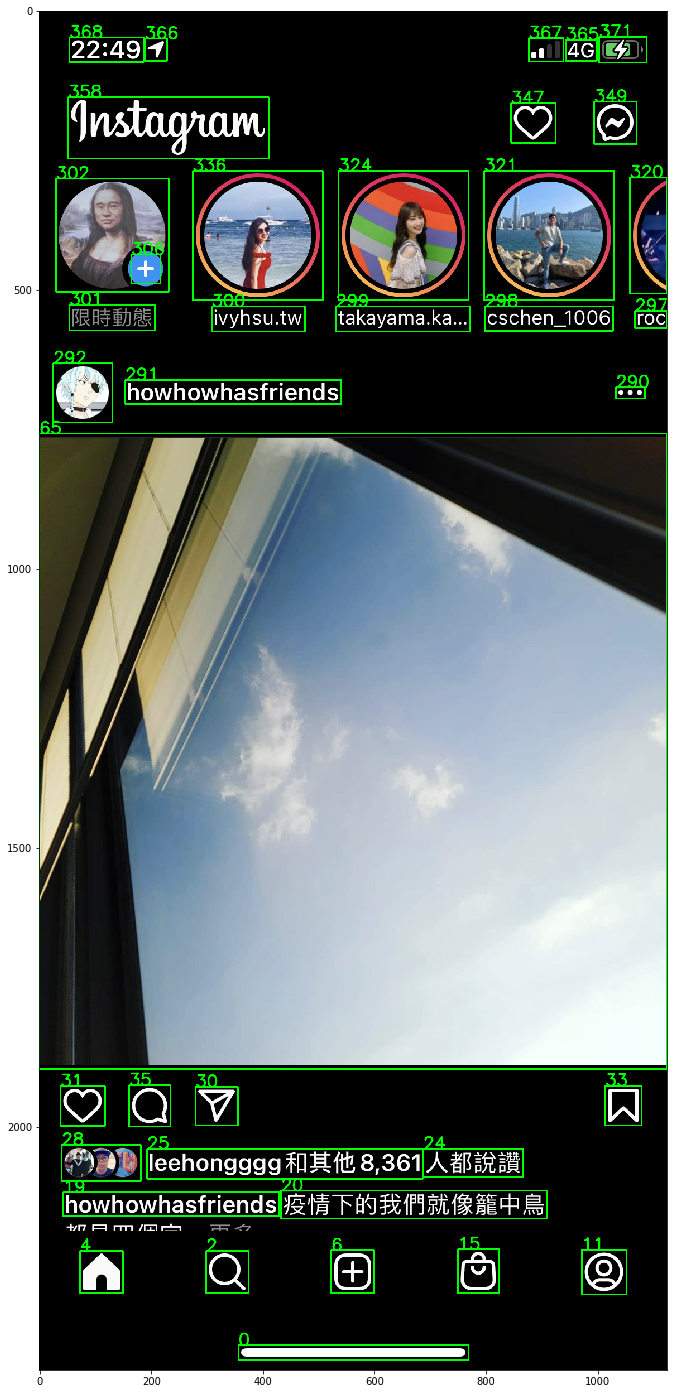

In [6]:
%%time
##辨識截圖上的文字並且加入contourInfo
## concurrent.futures version
from addText import *
reload(sys.modules['addText'])
from addText import *

import tesserocr
import pytesseract

from PIL import Image
import concurrent.futures
import queue

import time
import os

NUM_THREADS = os.cpu_count()
NUM_THREADS = 8
print('Logical Processors: ',NUM_THREADS)
#tesserocr_queue = queue.Queue()

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.fastNlMeansDenoising(img_gray)
#denoising


for t_num in range(NUM_THREADS):
    tesserocr_queue.put([t_num, tesserocr.PyTessBaseAPI(lang='eng+chi_tra',psm=6)])

start = time.time()

#from itertools import repeat
with concurrent.futures.ThreadPoolExecutor(NUM_THREADS) as executor:
    futures = {executor.submit(addText, c, img_gray): c for c in contourInfo}
    concurrent.futures.wait(futures)
#     futures = executor.map(addText, contourInfo, repeat(img_gray))
#     concurrent.futures.wait(futures)
    
    
end = time.time()
print('took tot: ' + str(end - start))
for _ in range(NUM_THREADS):
    t_num, api = tesserocr_queue.get(block=True)
    api.End()
    
    
clone3 = img.copy()
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(clone3, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone3, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        

plt.figure(figsize=(50,25))
clone3 = cv2.cvtColor(clone3, cv2.COLOR_BGR2RGB)
plt.imshow(clone3)

##tesserocr: 
# img_crop = cv2.cvtColor(img_crop, cv2.COLOR_GRAY2RGB)
# pil_crop = Image.fromarray(img_crop)
# api.SetImage(pil_crop)
# ocrResult = api.GetUTF8Text()
# conf = api.MeanTextConf()

##pytesseract:
# ocr = pytesseract.image_to_data(img_crop,lang='eng+chi_tra',config='--psm 6', output_type='data.frame')
# text = ocr[ocr.conf != -1]
# lines = text.groupby('block_num')['text'].apply(list)[1]
# conf = text.groupby(['block_num'])['conf'].mean()[1]
# ocrResult = ''.join(lines)




0 [[0, [2, -1, 1, -1]], [357, 2391, 412, 26], ['CY', 25]]
1 [[2, [4, 0, 3, -1]], [299, 2222, 76, 76], ['Q', 92]]
2 [[4, [6, 2, 5, -1]], [73, 2222, 77, 76], ['A', 94]]
3 [[6, [11, 4, 7, -1]], [523, 2221, 77, 77], ['(+)', 89]]
4 [[11, [15, 6, 12, -1]], [972, 2220, 80, 80], ['©', 48]]
5 [[15, [18, 11, 16, -1]], [750, 2219, 74, 79], ['台', 64]]
6 [[19, [20, 18, -1, -1]], [43, 2117, 387, 43], ['howhowhasfriends', 87]]
7 [[20, [24, 19, 21, -1]], [433, 2114, 477, 50], ['疫情下的我們就像籠中鳥', 77]]
8 [[24, [25, 20, -1, -1]], [688, 2039, 179, 50], ['人都說讚', 90]]
9 [[25, [28, 24, 26, -1]], [193, 2039, 494, 54], ['leehonggggfUHitt8,361', 72]]
10 [[28, [30, 25, 29, -1]], [40, 2032, 142, 65], ['Pwd', 52]]
11 [[30, [31, 28, -1, -1]], [280, 1928, 76, 69], ['V', 79]]
12 [[31, [33, 30, 32, -1]], [38, 1927, 80, 71], ['(2', 80]]
13 [[33, [35, 31, 34, -1]], [1014, 1926, 65, 71], ['A', 76]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
15 [[65, [290, 64, 66, -1]], [0, 757, 1125, 1139], ['/', 86]]
16 [[2

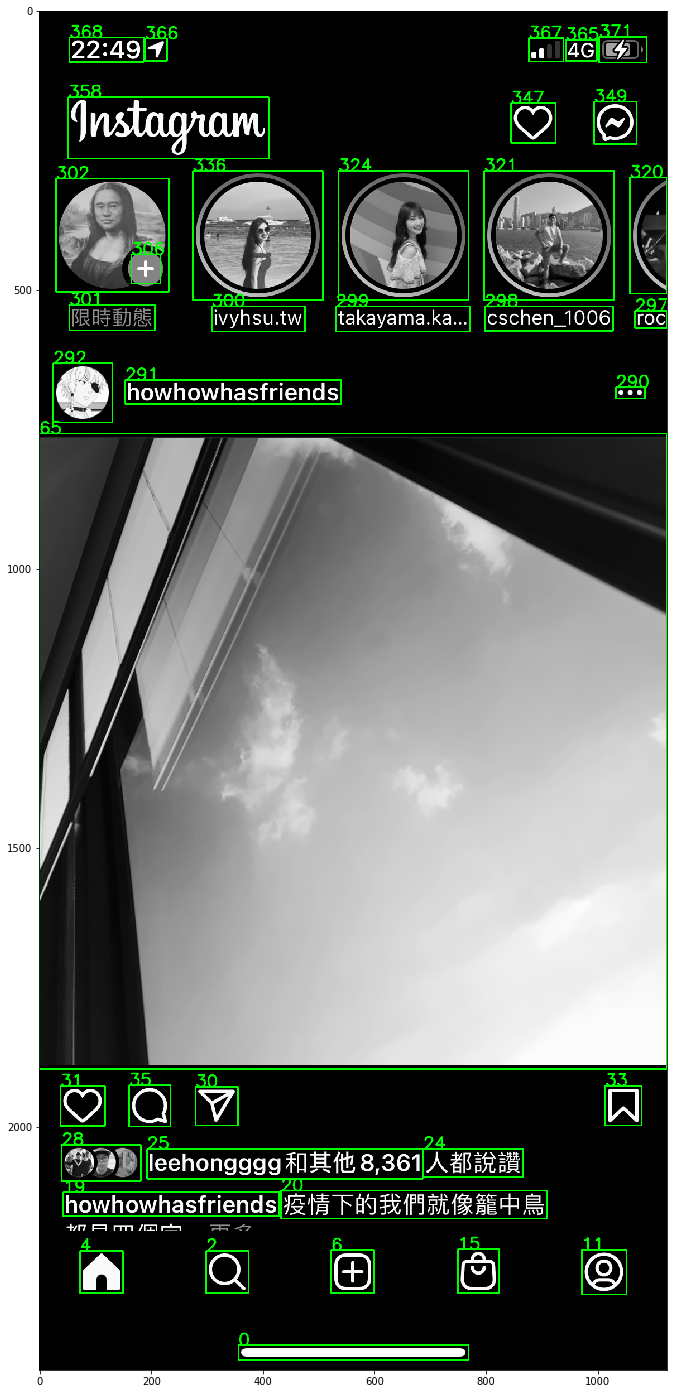

In [67]:
# import threading
# import multiprocessing as mp

# tesserocr.get_languages()
for i, c in enumerate(contourInfo):
    print(i, c)
# print(len(contourInfo))


# import concurrent.futures



# def say_hello_to(name):
#     print(name)
#     return f'Hi, {name}'


# names = ['John', 'Ben', 'Bill', 'Alex', 'Jenny'] * 10


# with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
#     results = {executor.submit(say_hello_to, name): name for name in names}
#     concurrent.futures.wait(results)
print(img.shape)
plt.figure(figsize=(50,25))
sss = cv2.cvtColor(img_gray.copy(), cv2.COLOR_BGR2RGB)
for c in contourInfo:
    x,y,w,h = c[1]
    cv2.rectangle(sss, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(sss, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
plt.imshow(sss)

dilate
monty 66 [66]


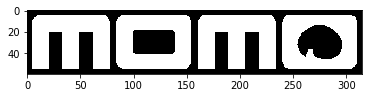

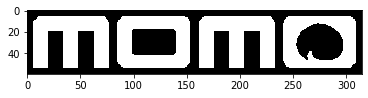

In [12]:
##ocr test for one contour
api = tesserocr.PyTessBaseAPI(lang='eng+chi_tra',psm=6)
img = cv2.imread('iosScreenshot/IMG_'+IMAGE_NUMBER+'.png', 1)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_gray = cv2.fastNlMeansDenoising(img_gray)
x,y,w,h = contourInfo[64][1]
# # x = int(x+0.02*w)
# # y = int(y+0.05*h)
# # w = int(0.96*w)
# # h = int(0.9*h)
flag=0
for j in range(1):
    ratio = [h/(h+w), w/(h+w)]
    s = 0.1*j*w if w>h else 0.1*j*h
    ratio = [int(s*k) for k in ratio]
    ##要設定s還是固定距離就好？？
    y_low = y-ratio[0] if y-ratio[0]>=0 else 0
    y_upp = y+h+ratio[0] if y+h+ratio[0]<img_gray.shape[0] else img_gray.shape[0]
    x_low = x-ratio[1] if x-ratio[1]>=0 else 0
    x_upp = x+w+ratio[1] if x+w+ratio[1]<img_gray.shape[1] else img_gray.shape[1]
    #img_crop = img_gray[y-ratio[0]:y+h+ratio[0], x-ratio[1]:x+w+ratio[1]].copy()
    img_crop = img_gray[y_low:y_upp, x_low:x_upp].copy()
    hc,wc = img_crop.shape
    if j==0: mean_crop = np.average(img_crop)
    if mean_crop <= 140:
        ret,img_crop = cv2.threshold(img_crop,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        ret,img_crop = cv2.threshold(img_crop,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ##binarize

    if y_low!=0: 
        img_crop[0:ratio[0],:] = 255
        img_crop[ratio[0]+h:hc,:] = 255
    else: 
        img_crop[0:y,:] = 255
        img_crop[y+h:hc,:] = 255

    if x_low!=0: 
        img_crop[:,0:ratio[1]] = 255
        img_crop[:,ratio[1]+w:wc] = 255
    else: 
        img_crop[:,0:x] = 255
        img_crop[:,x+w:wc] = 255
    ##等比例拉遠並把外圍pixel設為255

    #img_crop = cv2.resize(img_crop, (int(wc*10),int(hc*10)))
    #圖片放大
    img_crop = cv2.cvtColor(img_crop, cv2.COLOR_GRAY2RGB)
    pil = Image.fromarray(img_crop)
    api.SetImage(pil)
    ocrResult = api.GetUTF8Text()
    conf = api.MeanTextConf()
    
    ##直接切割圖片後各自辨識
    


    if conf==0: flag+=1 
    else: flag=0
    if conf<=70:
        kernel = np.ones((3,3), np.uint8)
        img_crop_ero = cv2.erode(img_crop, kernel, iterations = 1)
        pil = Image.fromarray(img_crop_ero)
        api.SetImage(pil)
        ocrResult1 = api.GetUTF8Text()
        conf1 = api.MeanTextConf()
        


        img_crop_dil = cv2.dilate(img_crop, kernel, iterations = 1)
        pil = Image.fromarray(img_crop_dil)
        api.SetImage(pil)
        ocrResult2 = api.GetUTF8Text()
        conf2 = api.MeanTextConf()
        


        if conf1>=conf2:
            ocrResult = ocrResult1
            conf = conf1
            print('erode')
            plt.figure()
            plt.imshow(img_crop_ero)
        else:
            ocrResult = ocrResult2
            conf = conf2
            print('dilate')
            plt.figure()
            plt.imshow(img_crop_dil)
            ##辨識不出來就加粗字體or變細

        if conf==0: flag+=1 
        else: flag=0
    ocrResult = ocrResult.strip().replace(" ","").replace("\n"," ")   
    print(ocrResult,conf, api.AllWordConfidences())
    plt.figure()
    plt.imshow(img_crop)

    if conf>=95 or (conf>=80 and j>=3) or (conf>=70 and j>=10) or flag==4: pass

# plt.imshow(img_crop)






14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
15 [[33, [35, 31, 34, -1]], [1014, 1926, 65, 71], ['A', 76]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
16 [[31, [33, 30, 32, -1]], [38, 1927, 80, 71], ['(2', 80]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
17 [[30, [31, 28, -1, -1]], [280, 1928, 76, 69], ['V', 79]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
18 [[28, [30, 25, 29, -1]], [40, 2032, 142, 65], ['Pwd', 52]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
19 [[25, [28, 24, 26, -1]], [193, 2039, 494, 54], ['leehonggggfUHitt8,361', 72]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
20 [[24, [25, 20, -1, -1]], [688, 2039, 179, 50], ['人都說讚', 90]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
21 [[20, [24, 19, 21, -1]], [433, 2114, 477, 50], ['疫情下的我們就像籠中鳥', 77]]
14 [[35, [37, 33, 36, -1]], [161, 1925, 74, 74], ['Q', 92]]
22 [[19, [20, 18, -1, -1]], [43, 2117, 387, 43], ['howhowhasf

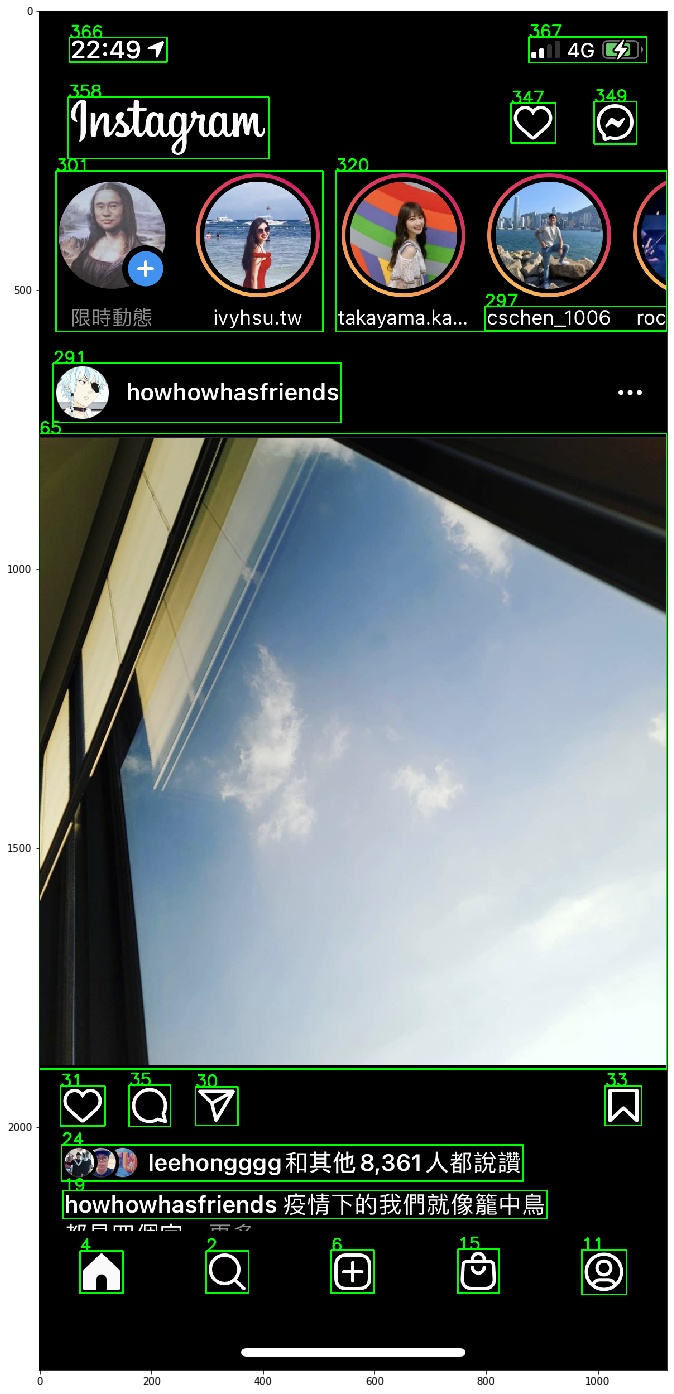

In [70]:
##c,d distance limitation
#d in c: upper left and (center or y_axis dist)
#c in d: upper left and (center or y_axis dist)
#d on right of c: (d's upper left - c's upper right) or (d's bottom left - c's bottom right) and (center or y_axis dist)
#d on left of c: (d's upper right - c's upper left) or (d's bottom right - c's bottom left)and (center or y_axis dist)
#d at top:(d's bottom left - c's upper left) or (d's bottom right - c's upper right) and center
#d at bottom:(d's upper left - c's bottom left) or (d's upper right - c's bottom right) and center

##combine contours that might be in the same element
#print(contourInfo)
#[[輪廓編號, 輪廓hier資訊],[x,y,w,h],[輪廓文字,confidence]]
import math 
from combineContour import *
reload(sys.modules['combineContour'])
from combineContour import *

sizeOG = img.shape
h,w,_ = img.shape
dist_factor = (w*0.01,h*0.01) if w<h else (h*0.01,w*0.01)
contourInfo_new = contourInfo.copy()
contourInfo_new.reverse()

        

contourInfo_new = combineContour(contourInfo_new, sizeOG)

print('before combine: ', len(contourInfo))
print('after combine1: ', len(contourInfo_new))
contourInfo_new = combineContour(contourInfo_new, sizeOG)
print('after combine2: ', len(contourInfo_new))
contourInfo_new = combineContour(contourInfo_new, sizeOG)
print('after combine3: ', len(contourInfo_new))



clone4 = img.copy()
for i,c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    cv2.rectangle(clone4, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(clone4, str(c[0][0]), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


cv2.imwrite('result/combined_'+IMAGE_NUMBER+'.jpg', clone4)
plt.figure(figsize=(50,25))
clone4 = cv2.cvtColor(clone4, cv2.COLOR_BGR2RGB)
plt.imshow(clone4)
for i in contourInfo_new:
    print(i)

In [57]:
f,l = dist_factor
print(f)
x1,y1,w1,h1= [30, 300, 202, 272] #d
x2,y2,w2,h2 = [275, 286, 233, 288] #c
x,y,w,h = [19, 1156, 834, 106]
mid_x1 = x1+(w1/2)
mid_y1 = y1+(h1/2)
mid_x2 = x2+(w2/2)
mid_y2 = y2+(h2/2)
center_dist = math.sqrt((mid_x1 - mid_x2)**2 + (mid_y1 - mid_y2)**2)
dtr_ctl = math.sqrt((x2 - (x1+w1))**2 + (y1 - y2)**2)
dbr_cbl = math.sqrt((x2 - (x1+w1))**2 + ((y1+h1) - (y2+h2))**2)
ctr_dtl = math.sqrt(((x2+w2) - x1)**2 + (y1 - y2)**2)
cbr_dbl = math.sqrt(((x2+w2) - x1)**2 + ((y1+h1) - (y2+h2))**2)

dbl_ctl = math.sqrt((x1 - x2)**2 + (y2 - (y1+h1))**2)
dbr_ctr = math.sqrt(((x1+w1) - (x2+w2))**2 + (y2 - (y1+h1))**2)
cbl_dtl = math.sqrt((x1 - x2)**2 + (y1 - (y2+h2))**2)
cbr_dtr = math.sqrt(((x1+w1) - (x2+w2))**2 + (y1 - (y2+h2))**2)

if x1>x2 and x1+w1>x2+w2 and (abs(mid_y1-mid_y2)<mid_x1-mid_x2):
    if (math.sqrt(((x2+w2) - x1)**2 + (y1 - y2)**2) <=f*4 or math.sqrt(((x2+w2) - x1)**2 + ((y1+h1) - (y2+h2))**2) <=f*4 or (x1 - (x2+w2))<=f*3.5 or x1<x2+w2) \
        and abs(mid_y1-mid_y2)<=f*5 and ((h1<f*25) or (h2<f*25)) and not((h1<f*12 and abs(h1-h2)<=0.5*f) or (abs(h1/w1 - h2/w2)<=0.05 and abs(h1+w1-(h2+w2))<=5*f and (x1 - (x2+w2))>=f*0.5)) and (abs(h1-h2)<=f*20):
        print('eee')



(dtr_ctl<=f*4 or dbr_cbl<=f*4 or (x2 - (x1+w1))<=f*3.5 or x2<x1+w1) \

(dtr_ctl<=f*4 or dbr_cbl<=f*4 or (x2 - (x1+w1))<=f*3.5 or x2<x1+w1) \
and not((abs(h1/w1 - h2/w2)<=0.05 or (abs(h1/w1 - h2/w2)<=0.15 and h1+w1<=15*f)) and abs(h1+w1-(h2+w2))<=6.5*f and (h1/w1<=3 and w1/h1<=3) and (x2 - (x1+w1))>=f*0.5) \
and (abs(h1-h2)<=f*20) and ((h1<f*25) or (h2<f*25)) \
and (abs(mid_y1-mid_y2)<=f*5 or (dtr_ctl<=f and abs(mid_y1-mid_y2)<=f*10) or (dbr_cbl<=f and abs(mid_y1-mid_y2)<=f*10)) \
and not(h1>10*f and abs(h1-h2)<0.5*f)


11.25


True

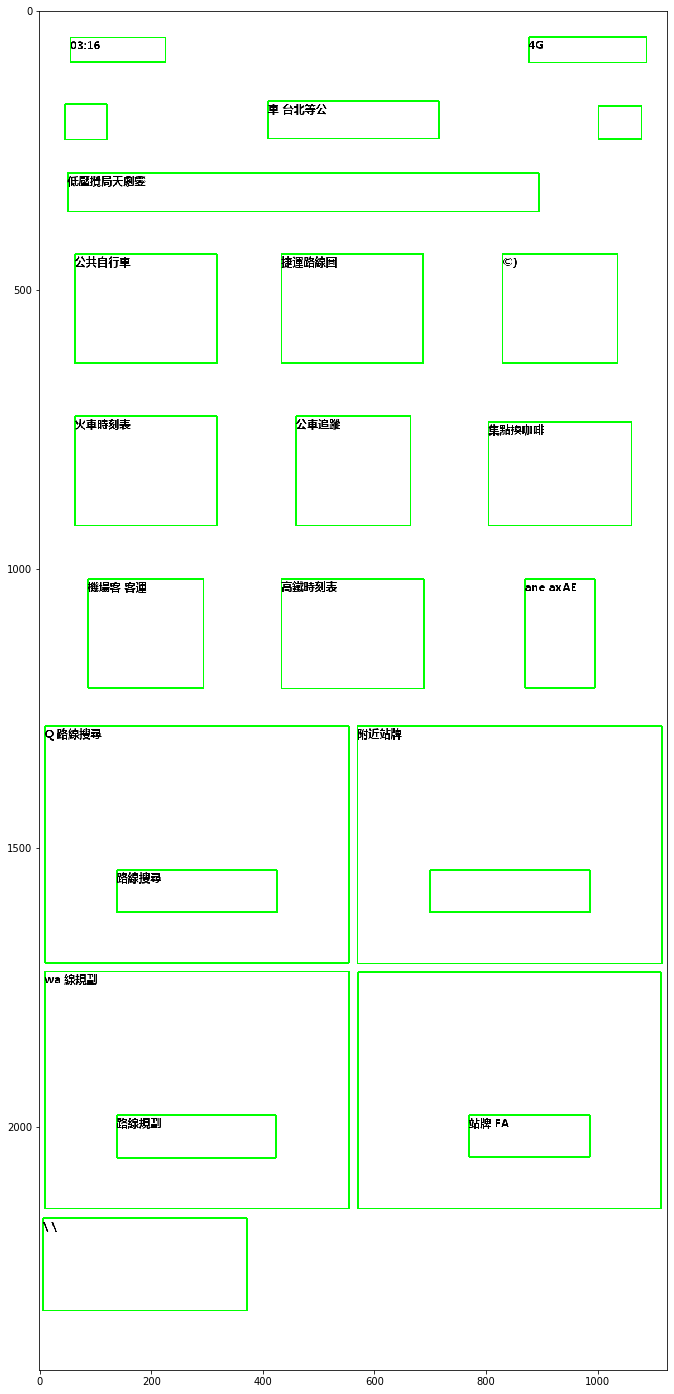

In [736]:
from PIL import Image, ImageDraw, ImageFont
clone5 = img.copy()
clone5[:][:][:] = 255
for i, c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    cv2.rectangle(clone5, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #cv2.putText(clone5, c[2][0], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

clone5 = cv2.cvtColor(clone5, cv2.COLOR_BGR2RGB)
pil5 = Image.fromarray(clone5)
for i, c in enumerate(contourInfo_new):
    x,y,w,h = c[1]
    if c[2][1] >=70:
        draw = ImageDraw.Draw(pil5)
        fontText = ImageFont.truetype('msyhbd.ttf' , 20, encoding="utf-8")
        draw.text((x, y), c[2][0], (0, 0, 0), font=fontText)


pil5.save('result/contour&text_'+IMAGE_NUMBER+'.jpg')
plt.figure(figsize=(50,25))
plt.imshow(pil5)


24
99 [100, 96, -1, -1] [875, 44, 215, 50]
text:  ['4G國,', 75]
100 [101, 99, -1, -1] [70, 45, 139, 48]
text:  ['03:55', 93]
96 [99, 89, 97, -1] [950, 185, 134, 134]
89 [96, 86, 90, -1] [45, 195, 219, 113]
text:  ['我的', 96]
74 [76, 73, 75, -1] [6, 459, 267, 181]
text:  ['回', 94]
73 [74, 72, -1, -1] [330, 459, 181, 181]
text:  ['個人頁面', 93]
72 [73, 71, -1, -1] [633, 459, 137, 181]
text:  ['追蹤中', 93]
71 [72, 70, -1, -1] [892, 459, 183, 181]
text:  ['播放紀錄', 96]
65 [70, 64, 66, -1] [40, 736, 327, 376]
text:  ['LIKES', 96]
63 [64, 60, -1, -1] [384, 851, 75, 42]
text:  ['Eric', 96]
60 [63, 57, 61, -1] [916, 865, 118, 118]
64 [65, 63, -1, -1] [383, 792, 205, 59]
text:  ['我的喜歡', 96]
57 [60, 56, 58, -1] [381, 981, 91, 82]
text:  ['1', 96]
41 [56, 38, 42, -1] [40, 1126, 327, 376]
text:  ['~™ OFFLINE', 85]
35 [38, 33, 36, -1] [916, 1255, 118, 118]
38 [41, 35, 39, -1] [384, 1182, 202, 101]
text:  ['離線歌曲 Eric', 93]
33 [35, 26, 34, -1] [381, 1371, 161, 82]
text:  ['(0/25)', 78]
26 [33, 25, 27, -1] [54

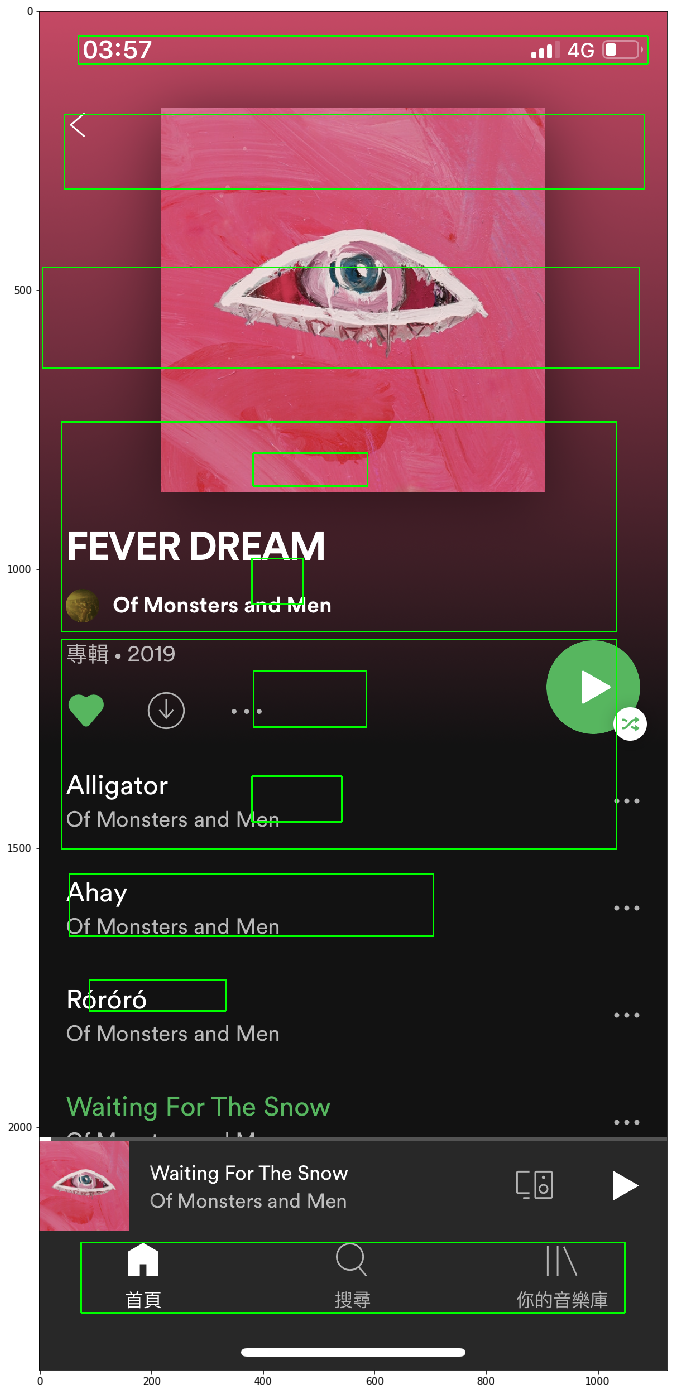

In [42]:
##產生截圖contour hierarchy的dict
import json
from generateDict import *
reload(sys.modules['generateDict'])
from generateDict import *


# with open('facebook.json', 'r') as fp:
#     j = json.load(fp)

# with open('facebook.json', 'w') as fp:
#     json.dump(j, fp, indent=4)

clone6 = img.copy()
mainDict, temp = generateJsonDict('test.json',img, contourInfo_new, sizeOG,clone6)
print('temp length: ', len(temp))

#clone6 = img.copy()
for i,c in enumerate(temp):
    x,y,w,h = c
    #cv2.rectangle(clone6, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.figure(figsize=(50,25))
clone6 = cv2.cvtColor(clone6, cv2.COLOR_BGR2RGB)
plt.imshow(clone6)

# generateXML('test.xml',img, contourInfo) 

number of contour result: 144
number of contours after filted by hierarchy: 48
number of contours after filted by size: 47
number of contours after filted out img noises: 44
Add Text Info
number of contours after combination:  28
Write to dict
The all vision Dict!
********
CPU times: user 18.1 s, sys: 658 ms, total: 18.8 s
Wall time: 10.1 s


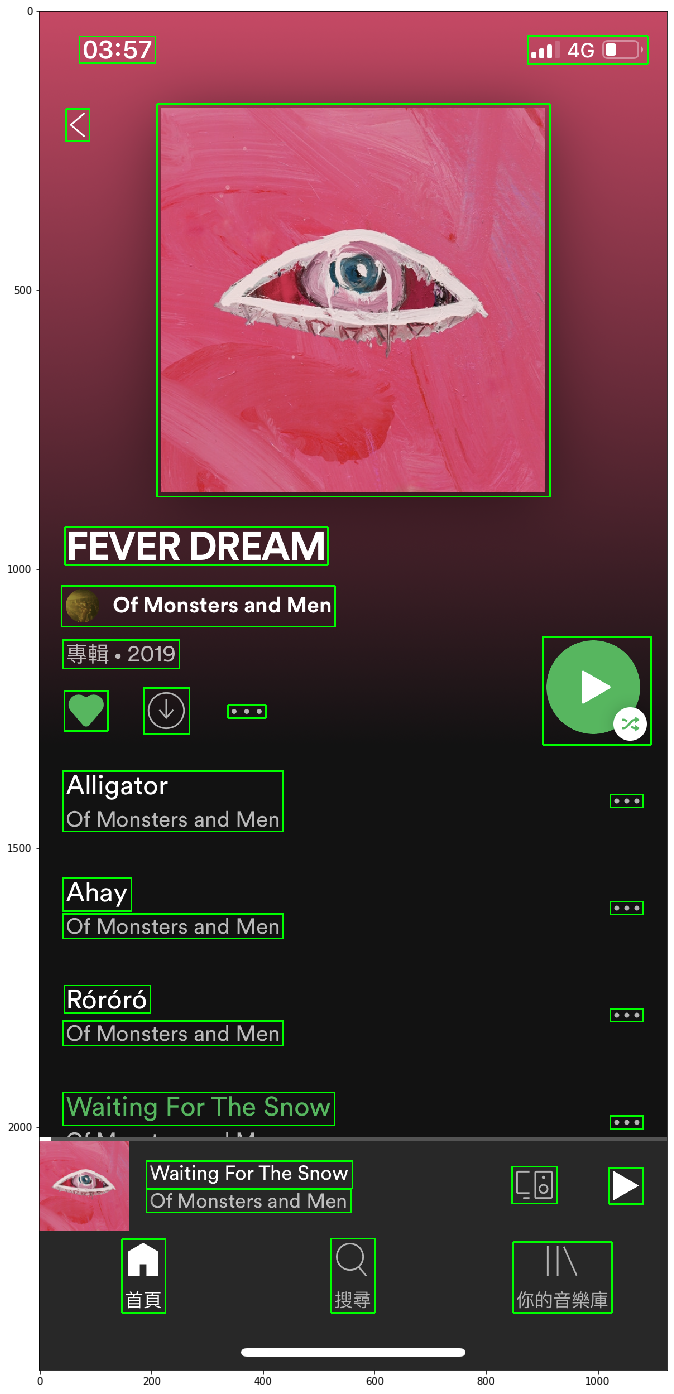

In [71]:
%%time
##class test
import cv2
from  matplotlib import pyplot as plt
from screenImageAnalyzer_test import screenImageAnalyzer
reload(sys.modules['screenImageAnalyzer_test'])
from screenImageAnalyzer_test import screenImageAnalyzer

img = cv2.imread('iosScreenshot/IMG_6318.png', 1)
cl = screenImageAnalyzer()
img = cl.getImage(img)
conDict, canvas, contours = cl.getVisionDict()

plt.figure(figsize=(50,25))
canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.imshow(canvas)

In [82]:
import json
print(json.dumps(conDict, indent=4))
print(conDict)
for i,c in enumerate(contours):
    x,y,w,h = c[1]
    print(c)
    

{
    "_EA@isEnabled": true,
    "_EA@class": "XCUIElementTypeOther",
    "_EA@isHidden": false,
    "_EA@isClickable": false,
    "tag": "ol",
    "_TaaD::byVision": true,
    "x": 0,
    "y": 0,
    "width": 1125,
    "height": 2436,
    "child": [
        {
            "_EA@isEnabled": true,
            "_EA@class": "XCUIElementTypeOther",
            "_EA@isHidden": false,
            "_EA@isClickable": false,
            "tag": "li",
            "_TaaD::byVision": true,
            "x": 72,
            "y": 44,
            "width": 1018,
            "height": 50,
            "child": [
                {
                    "_EA@isEnabled": true,
                    "_EA@class": "XCUIElementTypeButton",
                    "_EA@isHidden": false,
                    "_EA@isClickable": true,
                    "tag": "button",
                    "op": "click",
                    "_TaaD::byVision": true,
                    "x": 875,
                    "y": 44,
                   

In [667]:
import copy
q = [1,2,3,4,5,6,7,[8]]
p = q.copy()
p = p.copy()

for c in p:
    if c==[8]:
        c.append(10)
        p.remove(c)
        

print(q)   
print(p)

for a,b in zip([1,2],[3,4]):
    print(a,b)

[1, 2, 3, 4, 5, 6, 7, [8, 10]]
[1, 2, 3, 4, 5, 6, 7]
1 3
2 4


In [482]:
unique, counts = np.unique(img_gray, return_counts=True)
print(max(counts),len(counts),len(unique))
unique

479401 256 256


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [683]:
a = [1,2,3,4,5]
# while len(a)>0:
#     c = a[0]
#     print('c',c)
#     for d in a[1:4]:
#         print('d',d)
#         a.remove(d)
#     a.remove(c)
    
for d in a:
    print(d)
    if d>2:
        a.remove(d)

s = [1,[2],3,[4],[4]]
s = set(tuple(s))
print(list(s))

1
2
3
5


TypeError: unhashable type: 'list'

In [66]:
a = [1,1,2,2,3,4]
print(True in (i in [1,3,2] for i in a) or True in (i==2 for i in a))

True
